In [1]:
import pandas as pd
import numpy as np
import tqdm
import vectorbt as vbt
import quantstats as qs
import matplotlib.pyplot as plt
qs.extend_pandas()
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

In [2]:
台指資料 = pd.read_table(rf'C:\Users\Tedddddddd\Desktop\Ted\project2\data\台指資料.txt',encoding = 'ANSI').iloc[1:].drop(columns = ['期貨名稱','簡稱']).set_index('日期').astype(float)
台指資料.index = pd.to_datetime(台指資料.index)
台指資料

,開盤價,最高價,最低價,收盤價,成交張數(量)
日期,,,,,
1998-07-21,8131.0,8131.0,8036.0,8045.0,208.0
1998-07-22,7950.0,7950.0,7820.0,7870.0,360.0
1998-07-23,7830.0,7859.0,7802.0,7825.0,190.0
1998-07-24,7750.0,7835.0,7740.0,7835.0,340.0
1998-07-27,7830.0,7835.0,7780.0,7786.0,150.0
...,...,...,...,...,...
2023-10-12,16768.0,16857.0,16725.0,16848.0,76196.0
2023-10-13,16750.0,16807.0,16730.0,16770.0,67885.0
2023-10-16,16661.0,16683.0,16603.0,16648.0,101143.0


In [3]:
close_price = 台指資料['收盤價']
open_price = 台指資料['開盤價']

In [4]:
def get_bt_long_ret(param:int,entry_price):
    SMA = close_price.rolling(param).mean()
    EMA = close_price.ewm(span=param, adjust=False).mean()
    pf = vbt.Portfolio.from_signals(entry_price,
                                    entries = SMA>=EMA,
                                    exits = SMA<EMA,
                                    #short_entries = SMA<EMA,
                                    #short_exits = SMA>=EMA,
                                   )
    return param,pf.returns()
def get_bt_short_ret(param:int,entry_price):
    SMA = close_price.rolling(param).mean()
    EMA = close_price.ewm(span=param, adjust=False).mean()
    pf = vbt.Portfolio.from_signals(entry_price,
                                    #entries = SMA>=EMA,
                                    #exits = SMA<EMA,
                                    short_entries = SMA<EMA,
                                    short_exits = SMA>=EMA,
                                   )
    return param,pf.returns()

In [6]:
from joblib import Parallel, delayed
long_result_dict = dict(Parallel(n_jobs=-1)(delayed(get_bt_long_ret)(param,open_price.shift(-1)) for param in range(1,700)))
short_result_dict = dict(Parallel(n_jobs=-1)(delayed(get_bt_short_ret)(param,open_price.shift(-1)) for param in range(1,700)))

In [8]:
long_result_df = pd.DataFrame(long_result_dict)
short_result_df = pd.DataFrame(short_result_dict)

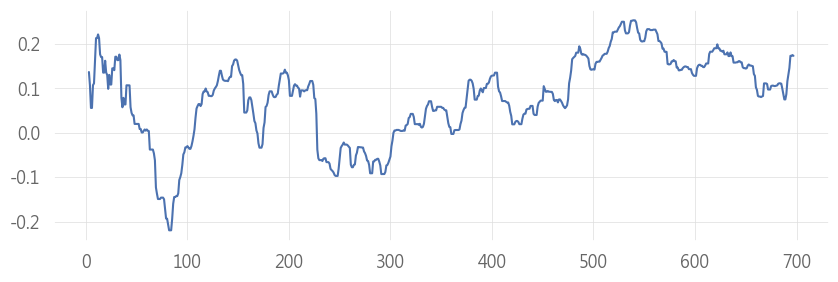

In [9]:
long_parameter_plateau = long_result_df.loc[:'2012'].sharpe().rolling(5).median().shift(-2)
long_parameter_plateau.plot(figsize=(10,3))
long_cycle_strategy_ret = long_result_df.loc[:,long_parameter_plateau>=0.2]

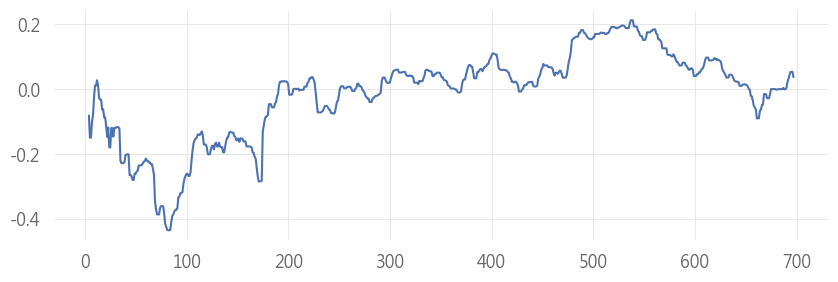

In [10]:
short_parameter_plateau = short_result_df.loc[:'2012'].sharpe().rolling(5).median().shift(-2)
short_parameter_plateau.plot(figsize=(10,3))
short_cycle_strategy_ret = short_result_df.loc[:,short_parameter_plateau>=0.1]

,cagr(%),MDD(%),sharpe
short_strategy,-2.0240,-62.3262,-0.054325
long_strategy,4.0875,-23.3155,0.624414
LS_strategy,6.2246,-31.0602,0.753001
benchmark,5.0849,-31.4141,0.549867


<Axes: xlabel='日期'>

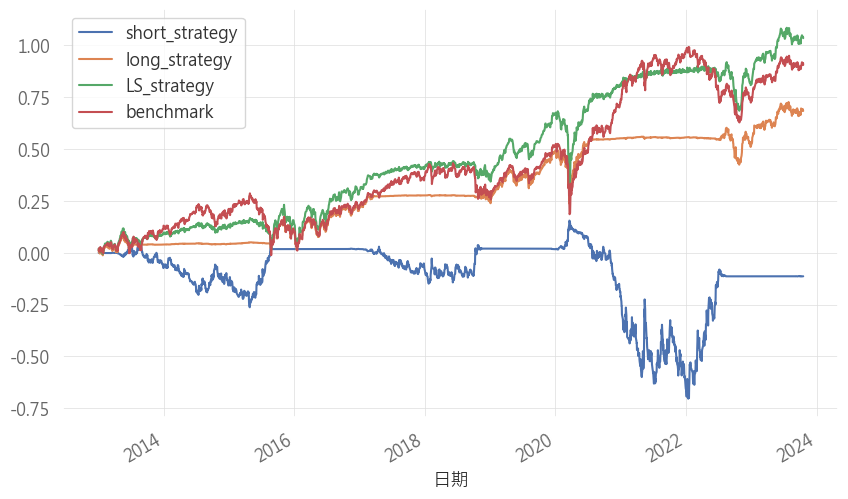

In [11]:
Leverage_multiple = 2
bt_reault_ret = pd.concat({
                           "short_strategy":short_cycle_strategy_ret.mean(axis = 1),
                           "long_strategy":long_cycle_strategy_ret.mean(axis = 1),
                           "LS_strategy":pd.concat([(1/3)*short_cycle_strategy_ret.mean(axis = 1),long_cycle_strategy_ret.mean(axis = 1),(open_price/open_price.shift()-1)],axis = 1).mean(axis = 1)*Leverage_multiple,
                           "benchmark":open_price/open_price.shift()-1},axis = 1).loc['2013':]
display(pd.concat({'cagr(%)':(bt_reault_ret.cagr()*100).round(4),'MDD(%)':(bt_reault_ret.max_drawdown()*100).round(4),'sharpe':bt_reault_ret.sharpe()},axis = 1))
bt_reault_ret.cumsum().plot()

In [12]:
def get_bt_long_singal(param:int,entry_price):
    SMA = close_price.rolling(param).mean()
    EMA = close_price.ewm(span=param, adjust=False).mean()
    return param,SMA>=EMA
def get_bt_short_singal(param:int,entry_price):
    SMA = close_price.rolling(param).mean()
    EMA = close_price.ewm(span=param, adjust=False).mean()
    return param,SMA<EMA

In [13]:
from joblib import Parallel, delayed
long_singal_df = pd.DataFrame(dict(Parallel(n_jobs=-1)(delayed(get_bt_long_singal)(param,open_price.shift(-1)) for param in range(1,700))))
short_singal_df = pd.DataFrame(dict(Parallel(n_jobs=-1)(delayed(get_bt_short_singal)(param,open_price.shift(-1)) for param in range(1,700))))

In [14]:
long_singal_Se = long_singal_df.loc[:,long_parameter_plateau>=0.2].astype(int).mean(axis = 1)
short_singal_Se = short_singal_df.loc[:,short_parameter_plateau>=0.1].astype(int).mean(axis = 1)

cagr(%)     8.45
MDD(%)    -36.50
sharpe      0.68
dtype: float64

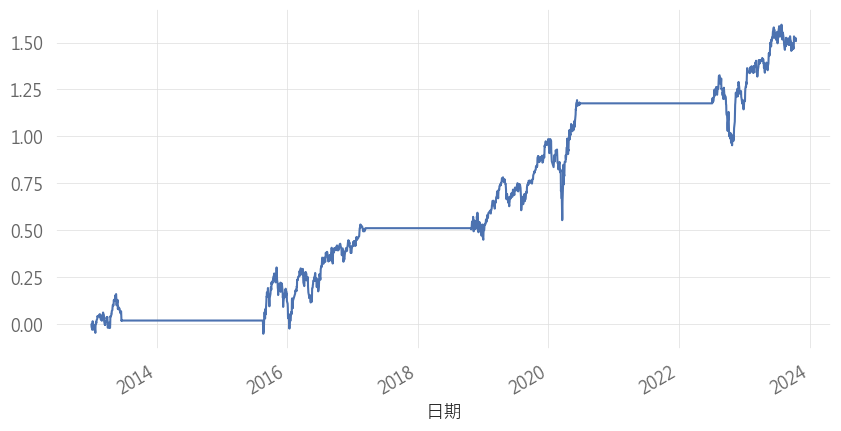

<Axes: xlabel='日期'>

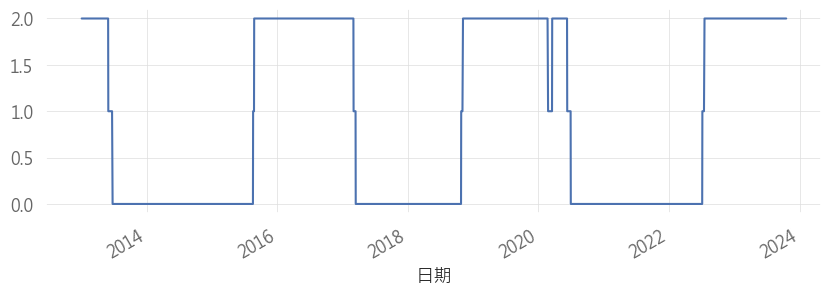

In [15]:
exp_ret = (open_price/open_price.shift()-1).shift(-2)
pos = ((long_singal_Se>=0.5).astype(int) + 1 - (short_singal_Se>=0.5).astype(int)).round()
Ret = (exp_ret * pos).loc['2013':]
display(pd.Series({'cagr(%)':(Ret.cagr()*100),'MDD(%)':(Ret.max_drawdown()*100),'sharpe':Ret.sharpe()}).round(2))
Ret.cumsum().plot(figsize=(10,5))
plt.show()
pos.loc['2013':].plot(figsize=(10,3))

In [16]:
import yfinance as yf

In [17]:
def get_data(pool:list = ["VPU","XLK","XLB","VNQ","XLI","XLV","XLF","XLE","XLP","XLY","VOX"])->pd.DataFrame:
    ohlc_df = yf.download(pool,ignore_tz=True)
    Adj_rate = ohlc_df['Adj Close']/ohlc_df['Close']
    ohlc_df['Close']*=Adj_rate
    ohlc_df['High']*=Adj_rate
    ohlc_df['Low']*=Adj_rate
    ohlc_df['Open']*=Adj_rate
    display(ohlc_df['Adj Close'][pool].apply(lambda x:x.dropna().index[0]))
    ohlc_df.columns.names = ['Load Data','assets']
    return ohlc_df.loc[:,(slice(None),pool)]

In [18]:
info_pool = ['QQQ','SPY','DIA','SOXX','SHY','VBMFX','VIPSX','IEF','TLT','GC=F','CL=F', 'QC=F', 'DX=F']
#target_by_stock = ['TQQQ','SPXL','UDOW','SOXL']
#target_by_bond = ['BND','IEF','TLT']
target_pool = ['收盤價']
rf_name = 'BIL'

In [19]:
ohlc_df = get_data(info_pool+[rf_name])
#target_ohlc_df = get_data(target_pool)
target_price_df = 台指資料[['收盤價']]#target_ohlc_df['Open'].reindex(ohlc_df.index,method = 'ffill')
BIL_ret = ohlc_df['Adj Close']['BIL'].pct_change()

[*********************100%%**********************]  14 of 14 completed


QQQ     1999-03-10
SPY     1993-01-29
DIA     1998-01-20
SOXX    2001-07-13
SHY     2002-07-30
VBMFX   1986-12-11
VIPSX   2000-06-29
IEF     2002-07-30
TLT     2002-07-30
GC=F    2000-08-30
CL=F    2000-08-23
QC=F    2002-05-23
DX=F    2000-06-22
BIL     2007-05-30
dtype: datetime64[ns]

C:\Users\Tedddddddd\AppData\Local\Temp\ipykernel_14680\4286645725.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  BIL_ret = ohlc_df['Adj Close']['BIL'].pct_change()


In [20]:
def get_EMA(price_df,period):
    EMA = price_df.ewm(span = period,min_periods = period//2).mean()
    EMA.columns = pd.MultiIndex.from_product([[period], price_df.columns], names=['period',None])
    return EMA
def get_SMA(price_df,period):
    SMA = price_df.rolling(window = period, min_periods= period//2).mean()
    SMA.columns = pd.MultiIndex.from_product([[period], price_df.columns], names=['period',None])
    return SMA

In [21]:
EMA_df = pd.concat(Parallel(n_jobs=-1)(delayed(get_EMA)(ohlc_df['Close'],period) for period in range(1,501,1)),axis = 1).ffill()
SMA_df = pd.concat(Parallel(n_jobs=-1)(delayed(get_SMA)(ohlc_df['Close'],period) for period in range(1,501,1)),axis = 1).ffill()

In [22]:
EMA_df = EMA_df.reindex(target_price_df.index,method = 'ffill')
SMA_df = SMA_df.reindex(target_price_df.index,method = 'ffill')

In [23]:
in_sample = '2013'
targets_ret_dict = dict()
for target_symbol in target_pool:
    print(f'\r{target_symbol}   ',end = '')
    pf = vbt.Portfolio.from_signals(target_price_df[target_symbol].shift(-1),
                                    entries = EMA_df.loc[:,(slice(None),info_pool)]>=SMA_df.loc[:,(slice(None),info_pool)],
                                    exits = EMA_df.loc[:,(slice(None),info_pool)]<SMA_df.loc[:,(slice(None),info_pool)],
                                    #short_entries = EMA_df.loc[:,(slice(None),info_pool)]<SMA_df.loc[:,(slice(None),info_pool)],
                                    #short_exits = EMA_df.loc[:,(slice(None),info_pool)]>=SMA_df.loc[:,(slice(None),info_pool)],
                                    fees = 0.1/100)
    pf_returns = pf.returns().loc[target_price_df.dropna().index[0]:]
    pf_returns.columns.names = ['period','assets']
    pf_returns = (pf_returns.T - BIL_ret).T
    pf_returns_insample = pf_returns.loc[:in_sample]

    sharpe_by_target_symbol = pf_returns_insample.stack().groupby('assets').mean() / pf_returns_insample.stack().groupby('assets').std() * (252**0.5)

    condition_1 = (sharpe_by_target_symbol.rank(axis = 1,ascending = False) <= 10)
    condition_2 = (sharpe_by_target_symbol > 0)
    condition_all = (condition_1 & condition_2).unstack()
    good_info_by_target_symbol = condition_all[condition_all].index
    target_symbol_ret = pf_returns[good_info_by_target_symbol].groupby('assets',axis = 1).mean().mean(axis = 1).dropna()
    targets_ret_dict[target_symbol] = target_symbol_ret
targets_ret_df = pd.DataFrame(targets_ret_dict)

收盤價   

C:\Users\Tedddddddd\AppData\Local\Temp\ipykernel_14680\1795095088.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  target_symbol_ret = pf_returns[good_info_by_target_symbol].groupby('assets',axis = 1).mean().mean(axis = 1).dropna()


In [24]:
pd.concat([Ret,targets_ret_df['收盤價']],axis = 1).mean(axis = 1).loc['2013':].cagr()

0.05326305058630476

<Axes: >

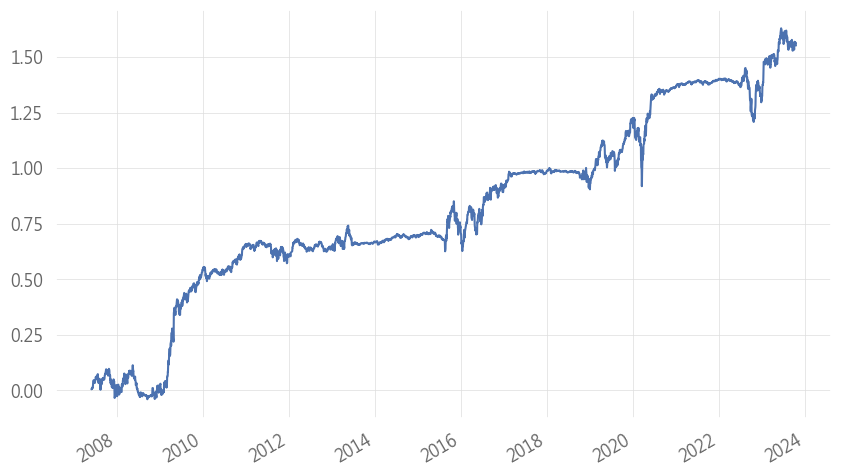

In [25]:
pd.concat([Ret,targets_ret_df['收盤價']],axis = 1).mean(axis = 1).cumsum().plot()